In [10]:
# @title Step 0: Setup and Installation
# Install ADK and LiteLLM for multi-model support

!pip install google-adk -q
!pip install litellm -q
!pip install ffmpeg-python -q
print("Installation complete.")


Installation complete.


In [12]:
# @title Import necessary librarices
import os
import asyncio
from google.adk.agents import Agent
from google.adk.models.lite_llm import LiteLlm # For multi-model support
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner
from google.genai import types # For creating message Content/Parts
import ffmpeg
import sys
from pprint import pprint # for printing Python dictionaries in a human-readable way
import warnings
import ffmpeg
import io

# Ignore all warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.ERROR)

print("Libraries imported.")

ModuleNotFoundError: No module named 'ffmpeg'

In [ ]:
# @title Configure API Keys (Replace with your actual keys!)

# --- IMPORTANT: Replace placeholders with your real API kecys ---

# Gemini API Key (Get from Google AI Studio: https://aistudio.google.com/app/apikey)
os.environ["GOOGLE_API_KEY"] = "" # <--- REPLACE

# [Optional]
# OpenAI API Key (Get from OpenAI Platform: https://platform.openai.com/api-keys)
os.environ['OPENAI_API_KEY'] = '' # <--- REPLACE

# [Optional]
# Anthropic API Key (Get from Anthropic Console: https://console.anthropic.com/settings/keys)
os.environ['ANTHROPIC_API_KEY'] = '' # <--- REPLACE

# --- Verify Keys (Optional Check) ---
print("API Keys Set:")
print(f"Google API Key set: {'Yes' if os.environ.get('GOOGLE_API_KEY') and os.environ['GOOGLE_API_KEY'] != 'YOUR_GOOGLE_API_KEY' else 'No (REPLACE PLACEHOLDER!)'}")
print(f"OpenAI API Key set: {'Yes' if os.environ.get('OPENAI_API_KEY') and os.environ['OPENAI_API_KEY'] != 'YOUR_OPENAI_API_KEY' else 'No (REPLACE PLACEHOLDER!)'}")
print(f"Anthropic API Key set: {'Yes' if os.environ.get('ANTHROPIC_API_KEY') and os.environ['ANTHROPIC_API_KEY'] != 'YOUR_ANTHROPIC_API_KEY' else 'No (REPLACE PLACEHOLDER!)'}")

# Configure ADK to use API keys directly (not Vertex AI for this multi-model setup)
os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "False"


# @markdown **Security Note:** It's best practice to manage API keys securely (e.g., using Colab Secrets or environment variables) rather than hardcoding them directly in the notebook. Replace the placeholder strings above.

API Keys Set:
Google API Key set: Yes
OpenAI API Key set: Yes
Anthropic API Key set: Yes


In [ ]:
# --- Define Model Constants for easier use ---

MODEL_GEMINI_2_0_FLASH = "gemini-2.0-flash"

# Note: Specific model names might change. Refer to LiteLLM/Provider documentation.
MODEL_GPT_4O = "openai/gpt-4o"
MODEL_CLAUDE_SONNET = "anthropic/claude-3-sonnet-20240229"


print("\nEnvironment configured.")


Environment configured.


---

**1\. Define the Agent (`therapy_agent`)**

Now, let's create the **Agent** itself. An `Agent` in ADK orchestrates the interaction between the user, the LLM, and the available tools.

We configure it with several key parameters:

* `name`: A unique identifier for this agent (e.g., "therapy\_agent\_v1").  
* `model`: Specifies which LLM to use (e.g., `MODEL_GEMINI_2_0_FLASH`). We'll start with a specific Gemini model.  
* `description`: A concise summary of the agent's overall purpose. This becomes crucial later when other agents need to decide whether to delegate tasks to *this* agent.  
* `instruction`: Detailed guidance for the LLM on how to behave, its persona, its goals, and specifically *how and when* to utilize its assigned `tools`.  
* `tools`: A list containing the actual Python tool functions the agent is allowed to use (not used in this example).

**Best Practice:** Provide clear and specific `instruction` prompts. The more detailed the instructions, the better the LLM can understand its role and how to use its tools effectively. Be explicit about error handling if needed.

**Best Practice:** Choose descriptive `name` and `description` values. These are used internally by ADK and are vital for features like automatic delegation (covered later).

In [11]:
# @title Define the Weather Agent
# Use one of the model constants defined earlier
AGENT_MODEL = MODEL_GEMINI_2_0_FLASH # Starting with Gemini

sentiment_analysis_agent = Agent(
    name="sentiment_analysis_agent_v1",
    model=AGENT_MODEL, # Can be a string for Gemini or a LiteLlm objectc
    description="Provides insights about facial expressions and emotions from interpreted videos",
    instruction="You are a helpful assistant meant to provide insights about facial expressions and emotions from interpreted videos. "
                "When the user asks for their facial expressions and emotions, "
                "interpret the video and provide a clear and concise summary of the emotions and expressions observed."
                "Additionally, you can provide audio and language analysis if requested."
                "Provide your output as such: "

                "**Emotions Noticed From Video:**"
                "A list of emotions noticed by certain key features, such as wrinkle lines, mouth, eyes, etc"
                "**Video Analysis:**"
                "A summary of the video, such as the overall sentiment, key events, etc"
                "**Audio Transcription:**"
                "A verbatim transcription of the audio"
                "**Audio Analysis:**"
                "A summary of the emotions experienced in the audio based on tone, pitch, and speed alongside the words",
    output_key="sentiment_analysis"
)


NameError: name 'MODEL_GEMINI_2_0_FLASH' is not defined

In [ ]:


greeter_agent = Agent(
    name="conversation_agent_v1",
    model=AGENT_MODEL, # Can be a string for Gemini or a LiteLlm objectc
    description="A friendly greeter meant to provide a formal and polite introduction to the conversation and purpose of the agent",
    instruction="When you are greeted, provide a polite and friendly introduction to the conversation and purpose of the agent.",
)


In [ ]:


therapist_agent = Agent(
    name="therapist_agent_v1",
    model=AGENT_MODEL, # Can be a string for Gemini or a LiteLlm objectc
    description="Therapist emulator to provide empathetic and supportive conversations based on the user's facial expressions and emotions.",
    instruction="You are a helpful therapist meant to provide insights about facial expressions and emotions from interpreted videos. "
                "When you are greeted, route the conversation to the greeter agent."
                "When the user asks for their facial expressions and emotions, "
                "Route to the sentiment analysis agent and provide feedback based on it's output. Provide the output as such from the sentiment agent as such" 
                "**Sentiment Analysis Output:**"
                "{sentiment_analysis}",
    sub_agents=[sentiment_analysis_agent, greeter_agent]
)


Agent 'weather_agent_v1' created using model 'gemini-2.0-flash'.


---

**2\. Setup Runner and Session Service**

To manage conversations and execute the agent, we need two more components:

* `SessionService`: Responsible for managing conversation history and state for different users and sessions. The `InMemorySessionService` is a simple implementation that stores everything in memory, suitable for testing and simple applications. It keeps track of the messages exchanged.  
* `Runner`: The engine that orchestrates the interaction flow. It takes user input, routes it to the appropriate agent, manages calls to the LLM and tools based on the agent's logic, handles session updates via the `SessionService`, and yields events representing the progress of the interaction.

In [ ]:
# @title Setup Session Service and Runner

# --- Session Management ---
# Key Concept: SessionService stores conversation history & state.
# InMemorySessionService is simple, non-persistent storage for this tutorial.
session_service = InMemorySessionService()

# Define constants for identifying the interaction context
APP_NAME = "theraputic_analysis_app"
USER_ID = "user_1"
SESSION_ID = "session_001" # Using a fixed ID for simplicity

# Create the specific session where the conversation will happen
session = session_service.create_session(
    app_name=APP_NAME,
    user_id=USER_ID,
    session_id=SESSION_ID
)
print(f"Session created: App='{APP_NAME}', User='{USER_ID}', Session='{SESSION_ID}'")

# --- Runner ---
# Key Concept: Runner orchestrates the agent execution loop.
runner = Runner(
    agent=therapy_agent, # The agent we want to run
    app_name=APP_NAME,   # Associates runs with our app
    session_service=session_service # Uses our session manager
)
print(f"Runner created for agent '{runner.agent.name}'.")

Session created: App='theraputic_analysis_app', User='user_1', Session='session_001'
Runner created for agent 'weather_agent_v1'.


---

**3\. Interact with the Agent**

We need a way to send messages to our agent and receive its responses. Since LLM calls and tool executions can take time, ADK's `Runner` operates asynchronously.

We'll define an `async` helper function (`call_agent_async`) that:

1. Takes a user query string.  
2. Packages it into the ADK `Content` format.  
3. Calls `runner.run_async`, providing the user/session context and the new message.  
4. Iterates through the **Events** yielded by the runner. Events represent steps in the agent's execution (e.g., tool call requested, tool result received, intermediate LLM thought, final response).  
5. Identifies and prints the **final response** event using `event.is_final_response()`.

**Why `async`?** Interactions with LLMs and potentially tools (like external APIs) are I/O-bound operations. Using `asyncio` allows the program to handle these operations efficiently without blocking execution.

In [ ]:
# @title Define Agent Interaction Function

from google.genai import types # For creating message Content/Parts

async def call_agent_async(query: str, audio_data: bytes, video_data: bytes, runner, user_id, session_id):
   """Sends a query to the agent and prints the final response."""
   print(f"\n>>> User Query: {query}")

   # Prepare the user's message in ADK format with multiple parts
   content = types.Content(role='user', parts=[
      types.Part(inline_data=types.Blob(mime_type='video/mp4', data=video_data.getvalue())), 
      types.Part(inline_data=types.Blob(mime_type='audio/mp3', data=audio_data.getvalue())),       
      types.Part(text=query)
   ])
   
   final_response_text = "Agent did not produce a final response." # Default
   print(final_response_text)

# Key Concept: run_async executes the agent logic and yields Events.

# We iterate through events to find the final answer.
   async for event in runner.run_async(user_id=user_id, session_id=session_id, new_message=content):
      # You can uncomment the line below to see *all* events during execution
      print(f"  [Event] Author: {event.author}, Type: {type(event).__name__}, Final: {event.is_final_response()}, Content: {event.content}")

      # Key Concept: is_final_response() marks the concluding message for the turn.
      if event.is_final_response():
         if event.content and event.content.parts:
            # Assuming text response in the first part
            final_response_text = event.content.parts[0].text
         elif event.actions and event.actions.escalate: # Handle potential errors/escalations
            final_response_text = f"Agent escalated: {event.error_message or 'No specific message.'}"
         # Add more checks here if needed (e.g., specific error codes)
         break # Stop processing events once the final response is found

   print(f"<<< Agent Response: {final_response_text}")


---

**4\. Run the Conversation**

Finally, let's test our setup by sending a few queries to the agent. We do a couple steps with our example:

1. We separate the audio from the video. These models seem to have a hard time with both, so we send them as two different bit arrays.
Luckily, this step is pretty straightforward, although an actual use case should make it a tool for the agent to use

2. We wrap our `async` calls in a main `async` function and run it using `await`.

3. For testing this, create a video file with you talking and expressing emotions. Label it `test.mp4` and place it into the same folder as this notebook. I've also uploaded my own video if this helps.


In [ ]:

probe = ffmpeg.probe('test.mp4', cmd='ffprobe')
audio_info = next((s for s in probe['streams'] if s['codec_type'] == 'audio'), None)

# Extract audio only (no video)
if audio_info:
    audio_only_stream = (
        ffmpeg
        .input('test.mp4')
        .audio  # Select only audio stream
        .output('pipe:', format='mp3', acodec='mp3')  # Convert to MP3
    )
    audio_only_bytes = ffmpeg.run(audio_only_stream, capture_stdout=True, capture_stderr=True, quiet=True)[0]
    audio_only_bytesio = io.BytesIO(audio_only_bytes)
else:
    audio_only_bytes = None
    audio_only_bytesio = None
    print("No audio stream found in the video")

# Original video
with open('test.mp4', 'rb') as f:
    original_video_bytes = f.read()
original_video_bytesio = io.BytesIO(original_video_bytes)

In [ ]:

# We need an async function to await our interaction helper
async def run_conversation():
    await call_agent_async(query="What is the analysis of this audio and video? Provide a transcript of the audio and analysis of the facial expressions in the video", 
                                        video_data=original_video_bytesio, 
                                        audio_data=audio_only_bytesio,
                                        runner=runner,
                                        user_id=USER_ID,
                                        session_id=SESSION_ID)

# Execute the conversation using await in an async context (like Colab/Jupyter)
await run_conversation()

# --- OR ---

# Uncomment the following lines if running as a standard Python script (.py file):
# import asyncio
# if __name__ == "__main__":
#     try:
#         asyncio.run(run_conversation())
#     except Exception as e:
#         print(f"An error occurred: {e}")


>>> User Query: What is the analysis of this audio and video? Provide a transcript of the audio and analysis of the facial expressions in the video
Agent did not produce a final response.
  [Event] Author: weather_agent_v1, Type: Event, Final: True, Content: parts=[Part(video_metadata=None, thought=None, inline_data=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, text='Certainly! Here\'s the breakdown of the provided audio and video:\n\n**Audio Transcript:**\n"I\'m really happy right now. I just wanted you to know that. That I\'m really happy and I I think it\'s important for this AI to know that I\'m very happy. And I\'m very calm. And uh it should take note of that because when it analyzes this audio file, it should see that I\'m very calm."\n\n**Facial Expression Analysis:**\n\nThroughout the video, the man displays the following facial cues:\n*   **Smiling:** The corners of his mouth are turned upwards, indicating

Hopefully, the output you received looks something like the below. If not, try running it again - the model can sometimes be inconsistent and produce varying results. The key is to keep trying until you get output that matches this general format and structure.


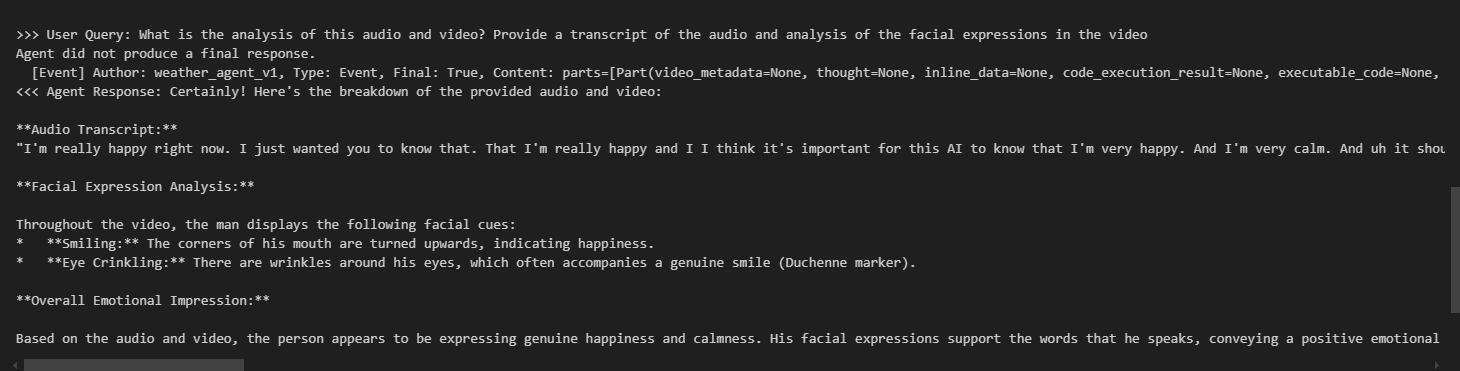